# Assignment 1: Power Calendar function
Objective: write R/Python function which returns number of hours by iso/peak.type/period
In power market, the industry defines certain hour of each day to peak type for block trading, so we need to calculate correctly how many hours belongs to certain block. Each ISO has a little different definition of it. Note: don't scrape data from the reference link. It's for reference only. You shall learn/understand the logic and calculate without access to any website.

See reference: https://www.energygps.com/HomeTools/PowerCalendar
Required Function: get.hours(iso, peak.type, period)
Params: (all params are required in the function)
iso (character): one of PJM/MISO/ERCOT/SPP/NYISO/WECC/CAISO (see item 1 below)
peak.type (character): one of onpeak/offpeak/flat/2x16H/7x8
period (character): has 4 types: “2018-2-3” as a daily, “2018Mar” as a monthly, “2018Q2” as a quarterly, “2018A” as an annually.

In [1]:
from datetime import datetime, timedelta
import pandas as pd

def get_hours(iso, peak_type, period):
    # defining peak hours
    peak_hours = {
        "onpeak": range(7, 23),
        "offpeak": list(range(1, 7)) + list(range(23, 25)),
        "flat": range(1, 25),
        "2x16H": range(7, 23),
        "7x8": list(range(1, 7)) + list(range(23, 25)),
    }

    # 4 different types of period formats
    if len(period) > 7:  # Daily
        startDate = datetime.strptime(period, "%Y-%m-%d")
        endDate = startDate
    elif len(period) == 7:  # Monthly
        startDate = datetime.strptime(period, "%Y%b")
        endDate = (startDate + pd.DateOffset(months=1) - timedelta(days=1)).to_pydatetime()
    elif len(period) == 6:  # Quarterly
        quarter = int(period[-1])
        startDate = datetime.strptime(period[:4] + '-' + str((quarter - 1) * 3 + 1), "%Y-%m")
        endDate = (startDate + pd.DateOffset(months=3) - timedelta(days=1)).to_pydatetime()
    elif len(period) == 5:  # Annually
        startDate = datetime.strptime(period[:4] + "-01-01", "%Y-%m-%d")
        endDate = datetime.strptime(period[:4] + "-12-31", "%Y-%m-%d")

    # all dates within period
    dates = pd.date_range(start=startDate, end=endDate, freq='D')
    # of hours tracker
    numHours = 0
    for date in dates:
        if peak_type.lower() == "2x16h" and (date.weekday() >= 5 or date in get_nerc_holidays(date.year)):
            numHours += len(peak_hours["2x16H"])
        elif peak_type.lower() == "7x8" and (date.weekday() < 5 and date not in get_nerc_holidays(date.year)):
            numHours += len(peak_hours["7x8"])
        elif peak_type.lower() == "onpeak" and date.weekday() < 5 and date not in get_nerc_holidays(date.year):  # Exclude saturdays and sundays
            numHours += len(peak_hours["onpeak"])
        elif peak_type.lower() != "onpeak" and date not in get_nerc_holidays(date.year):
            numHours += len(peak_hours[peak_type.lower()])

    return {
        'iso': iso,
        'peak_type': peak_type.upper(),
        'startdate': startDate.strftime("%Y-%m-%d"),
        'enddate': endDate.strftime("%Y-%m-%d"),
        'num_hours': numHours
    }

def get_nerc_holidays(year):
    holidays = ["New Year's Day", "Independence Day", "Christmas Day", "Memorial Day", "Labor Day","Thanksgiving Day",]
    holiday_dates = {"New Year's Day": datetime(year, 1, 1), "Independence Day": datetime(year, 7, 4), 
                     "Christmas Day": datetime(year, 12, 25), "Memorial Day": get_nth_weekday_of_month(year, 5, 0, -1),
                     "Labor Day": get_nth_weekday_of_month(year, 9, 0, 1),"Thanksgiving Day": get_nth_weekday_of_month(year, 11, 3, 4),}
    return [holiday_dates[holiday] for holiday in holidays]
def get_nth_weekday_of_month(year, month, weekday, n):
    if n > 0:
        first_day = datetime(year, month, 1)
        first_weekday = first_day + timedelta(days=(weekday - first_day.weekday() + 7) % 7)
        return first_weekday + timedelta(weeks=n-1)
    else:
        last_day = datetime(year, month + 1, 1) - timedelta(days=1)
        last_weekday = last_day - timedelta(days=(last_day.weekday() - weekday + 7) % 7)
        return last_weekday + timedelta(weeks=n+1)

# Example Usage:
results = get_hours("ERCOT", "onpeak", "2019May")
(results)

# Matches the output provided by github 


{'iso': 'ERCOT',
 'peak_type': 'ONPEAK',
 'startdate': '2019-05-01',
 'enddate': '2019-05-31',
 'num_hours': 352}

In [2]:
# testing cells to make sure calculating correctly 
tmp1 = pd.date_range(start="5/1/2019", end="5/31/2019")
tmp1

DatetimeIndex(['2019-05-01', '2019-05-02', '2019-05-03', '2019-05-04',
               '2019-05-05', '2019-05-06', '2019-05-07', '2019-05-08',
               '2019-05-09', '2019-05-10', '2019-05-11', '2019-05-12',
               '2019-05-13', '2019-05-14', '2019-05-15', '2019-05-16',
               '2019-05-17', '2019-05-18', '2019-05-19', '2019-05-20',
               '2019-05-21', '2019-05-22', '2019-05-23', '2019-05-24',
               '2019-05-25', '2019-05-26', '2019-05-27', '2019-05-28',
               '2019-05-29', '2019-05-30', '2019-05-31'],
              dtype='datetime64[ns]', freq='D')

In [3]:
# testing cells to make sure calculating correctly 
for i in tmp1:
    print(i.strftime('%Y-%m-%d') + " " + str(get_hours("ERCOT", "onpeak", i.strftime('%Y-%m-%d'))))

2019-05-01 {'iso': 'ERCOT', 'peak_type': 'ONPEAK', 'startdate': '2019-05-01', 'enddate': '2019-05-01', 'num_hours': 16}
2019-05-02 {'iso': 'ERCOT', 'peak_type': 'ONPEAK', 'startdate': '2019-05-02', 'enddate': '2019-05-02', 'num_hours': 16}
2019-05-03 {'iso': 'ERCOT', 'peak_type': 'ONPEAK', 'startdate': '2019-05-03', 'enddate': '2019-05-03', 'num_hours': 16}
2019-05-04 {'iso': 'ERCOT', 'peak_type': 'ONPEAK', 'startdate': '2019-05-04', 'enddate': '2019-05-04', 'num_hours': 0}
2019-05-05 {'iso': 'ERCOT', 'peak_type': 'ONPEAK', 'startdate': '2019-05-05', 'enddate': '2019-05-05', 'num_hours': 0}
2019-05-06 {'iso': 'ERCOT', 'peak_type': 'ONPEAK', 'startdate': '2019-05-06', 'enddate': '2019-05-06', 'num_hours': 16}
2019-05-07 {'iso': 'ERCOT', 'peak_type': 'ONPEAK', 'startdate': '2019-05-07', 'enddate': '2019-05-07', 'num_hours': 16}
2019-05-08 {'iso': 'ERCOT', 'peak_type': 'ONPEAK', 'startdate': '2019-05-08', 'enddate': '2019-05-08', 'num_hours': 16}
2019-05-09 {'iso': 'ERCOT', 'peak_type': '

# Assignment 2: Meter Data formatting

Objective: merge different data sources into single dataset and evaluate the dataset for anormaly (if any)
For analysis purpose, we always have different data sources to merge and format. It’s important to understand the data and format it correctly.


Data Files:
- USA_AL_Auburn-Opelika.AP.722284_TMY3_BASE.csv This file gives hourly electricity consumptions for a resident with unit in kw (kilowatt).
- new.app4.csv Assuming this is one appliance’s electricity consumption minute by minute which is not captured in the previous file. The unit in the file is in watt.


Requirements:
- Create script to load both files and merge.
- Given the limitation of data period, try to find the overlap period and merge the data into hourly. (ignore the year but making sure the date/hour matched)
- After merging the source files correctly, please create one more column in the output file to give total hourly consumption of electricity. (sum all columns)
- Create plots of the data and see if there’s any abnormal in the dataset and summarize any pattern observed from the data by hourl/weekday/month
- Write code with clear documentation.

Hint:
- try to show smart/efficient way to merge and sum column
- try not to hard code by column number or name but making the script re-usable for general data formatting

In [4]:
# Preliminary Data Visualization
dataAssignment2 = pd.read_csv("Documents/GitHub/GuzmanSummer2024/data/Assignment 2 - new.app4.csv")
dataAssignment2.head()

,Unnamed: 0,time,W_min
0,1,6/7/2013 11:04,1142.919571
1,2,6/7/2013 11:05,371.239567
2,3,6/7/2013 11:06,367.887333
3,4,6/7/2013 11:07,702.714100
4,5,6/7/2013 11:08,1655.944450


In [5]:
# Preliminary Data Visualization 
fileUSA = pd.read_csv("Documents/GitHub/GuzmanSummer2024/data/Assignment 2 - USA_AL_Auburn-Opelika.AP.722284_TMY3_BASE.csv")
fileUSA.head()

,Date/Time,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly)
0,01/01 01:00:00,0.974334,4.452977,0.0,4.425010,0.0,0.112709,0.112709,0.112709,0.154019,0.033180,0.092943,0.406035,0.158803
1,01/01 02:00:00,0.796582,4.850317,0.0,4.824566,0.0,0.122617,0.122617,0.122617,0.089845,0.019355,0.076186,0.373851,0.098084
2,01/01 03:00:00,0.735028,5.037645,0.0,5.012193,0.0,0.127099,0.127099,0.127099,0.064175,0.013825,0.062326,0.369517,0.081442
3,01/01 04:00:00,0.727433,5.107562,0.0,5.082468,0.0,0.128391,0.128391,0.128391,0.064175,0.013825,0.053976,0.364315,0.086107
4,01/01 05:00:00,0.778706,5.270878,0.0,5.246732,0.0,0.132549,0.132549,0.132549,0.064175,0.013825,0.065823,0.350553,0.135137


In [6]:
print(dataAssignment2.shape)
print(fileUSA.shape)

(10846, 3)
(8760, 14)


In [7]:
# Convert the 'time' column to datetime
dataAssignment2['time'] = pd.to_datetime(dataAssignment2['time'])
dataAssignment2.set_index('time', inplace=True)

# Aggregating the data from minute to hourly 
hourlyData = dataAssignment2.resample('H').sum()
hourlyData.reset_index(inplace=True)
hourlyData['time'] = hourlyData['time'].dt.strftime('%m/%d %H:%M:%S')
hourlyData["W_min"] = hourlyData["W_min"].div(1000)
hourlyData.rename({'time':'Date/Time', "W_min":"kW_min"}, axis=1, inplace = True)
hourlyData.drop("Unnamed: 0", axis = 1, inplace = True)
hourlyData.head()



/var/folders/vz/z83bk0kd7s5d4_3cx59yyqnw0000gn/T/ipykernel_17911/1042599370.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourlyData = dataAssignment2.resample('H').sum()


,Date/Time,kW_min
0,06/07 11:00:00,57.388943
1,06/07 12:00:00,27.227961
2,06/07 13:00:00,111.476298
3,06/07 14:00:00,109.021960
4,06/07 15:00:00,5.773963


We now have a dataframe that contains the aggregated hourly data, and converted from watts to kilowatts

In [8]:
fileUSA['Date/Time'] = fileUSA['Date/Time'].str.strip().str.replace('24:00:00', '00:00:00')
fileUSA['Date/Time'] = pd.to_datetime(fileUSA['Date/Time'], format='%m/%d %H:%M:%S')
fileUSA.loc[fileUSA['Date/Time'].dt.hour == 0, 'Date/Time'] += pd.DateOffset(days=1)
fileUSA['Date/Time'] = fileUSA['Date/Time'].dt.strftime('%m/%d %H:%M:%S')
fileUSA.head()

,Date/Time,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly)
0,01/01 01:00:00,0.974334,4.452977,0.0,4.425010,0.0,0.112709,0.112709,0.112709,0.154019,0.033180,0.092943,0.406035,0.158803
1,01/01 02:00:00,0.796582,4.850317,0.0,4.824566,0.0,0.122617,0.122617,0.122617,0.089845,0.019355,0.076186,0.373851,0.098084
2,01/01 03:00:00,0.735028,5.037645,0.0,5.012193,0.0,0.127099,0.127099,0.127099,0.064175,0.013825,0.062326,0.369517,0.081442
3,01/01 04:00:00,0.727433,5.107562,0.0,5.082468,0.0,0.128391,0.128391,0.128391,0.064175,0.013825,0.053976,0.364315,0.086107
4,01/01 05:00:00,0.778706,5.270878,0.0,5.246732,0.0,0.132549,0.132549,0.132549,0.064175,0.013825,0.065823,0.350553,0.135137


We now have a dataframe of the overall USA dataset that has the Date/Time column converted to match the format of the other 

In [9]:
a = hourlyData["Date/Time"][0]
a

'06/07 11:00:00'

In [10]:
tmp1 = fileUSA.iloc[3778:3779]
tmp2 = pd.DataFrame(tmp1)
tmp2

,Date/Time,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly)
3778,06/07 11:00:00,1.479426,0.018757,0.0,0.0,0.347519,0.100007,0.447526,0.100007,0.047163,0.01016,0.360615,0.272322,0.324996


In [11]:
a == tmp2["Date/Time"]

3778    True
Name: Date/Time, dtype: bool

In [12]:
combinedDatasetAssignment2 = fileUSA.merge(hourlyData, on='Date/Time', how = "left")
combinedDatasetAssignment2

,Date/Time,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly),kW_min
0,01/01 01:00:00,0.974334,4.452977,0.0,4.425010,0.0,0.112709,0.112709,0.112709,0.154019,0.033180,0.092943,0.406035,0.158803,NaN
1,01/01 02:00:00,0.796582,4.850317,0.0,4.824566,0.0,0.122617,0.122617,0.122617,0.089845,0.019355,0.076186,0.373851,0.098084,NaN
2,01/01 03:00:00,0.735028,5.037645,0.0,5.012193,0.0,0.127099,0.127099,0.127099,0.064175,0.013825,0.062326,0.369517,0.081442,NaN
3,01/01 04:00:00,0.727433,5.107562,0.0,5.082468,0.0,0.128391,0.128391,0.128391,0.064175,0.013825,0.053976,0.364315,0.086107,NaN
4,01/01 05:00:00,0.778706,5.270878,0.0,5.246732,0.0,0.132549,0.132549,0.132549,0.064175,0.013825,0.065823,0.350553,0.135137,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,12/31 20:00:00,2.601121,0.044507,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.743542,0.160179,0.349591,0.646167,0.684999,NaN
8756,12/31 21:00:00,2.445630,0.046038,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.677155,0.145877,0.310730,0.668381,0.626843,NaN
8757,12/31 22:00:00,2.206391,0.044963,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.570934,0.122994,0.293949,0.652777,0.549092,NaN
8758,12/31 23:00:00,1.769166,0.295330,0.0,0.256420,0.0,0.006642,0.006642,0.006642,0.424881,0.091531,0.234174,0.564895,0.430399,NaN


Utilizing a left join, we can merge the two datasets together based on their Date/Time column

In [13]:
combinedDatasetAssignment2["Hourly Sum"] = combinedDatasetAssignment2.drop('Date/Time', axis=1).sum(axis=1)
combinedDatasetAssignment2

,Date/Time,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly),kW_min,Hourly Sum
0,01/01 01:00:00,0.974334,4.452977,0.0,4.425010,0.0,0.112709,0.112709,0.112709,0.154019,0.033180,0.092943,0.406035,0.158803,NaN,11.035430
1,01/01 02:00:00,0.796582,4.850317,0.0,4.824566,0.0,0.122617,0.122617,0.122617,0.089845,0.019355,0.076186,0.373851,0.098084,NaN,11.496637
2,01/01 03:00:00,0.735028,5.037645,0.0,5.012193,0.0,0.127099,0.127099,0.127099,0.064175,0.013825,0.062326,0.369517,0.081442,NaN,11.757447
3,01/01 04:00:00,0.727433,5.107562,0.0,5.082468,0.0,0.128391,0.128391,0.128391,0.064175,0.013825,0.053976,0.364315,0.086107,NaN,11.885034
4,01/01 05:00:00,0.778706,5.270878,0.0,5.246732,0.0,0.132549,0.132549,0.132549,0.064175,0.013825,0.065823,0.350553,0.135137,NaN,12.323477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,12/31 20:00:00,2.601121,0.044507,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.743542,0.160179,0.349591,0.646167,0.684999,NaN,5.230105
8756,12/31 21:00:00,2.445630,0.046038,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.677155,0.145877,0.310730,0.668381,0.626843,NaN,4.920653
8757,12/31 22:00:00,2.206391,0.044963,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.570934,0.122994,0.293949,0.652777,0.549092,NaN,4.441100
8758,12/31 23:00:00,1.769166,0.295330,0.0,0.256420,0.0,0.006642,0.006642,0.006642,0.424881,0.091531,0.234174,0.564895,0.430399,NaN,4.086723


We now have the combined dataset, with the Hourly Sum column now integrated into the dataset as well. 
For visualization, it's included below. 

In [14]:
combinedDatasetAssignment2[["Date/Time", "Hourly Sum"]]

,Date/Time,Hourly Sum
0,01/01 01:00:00,11.035430
1,01/01 02:00:00,11.496637
2,01/01 03:00:00,11.757447
3,01/01 04:00:00,11.885034
4,01/01 05:00:00,12.323477
...,...,...
8755,12/31 20:00:00,5.230105
8756,12/31 21:00:00,4.920653
8757,12/31 22:00:00,4.441100
8758,12/31 23:00:00,4.086723


In [15]:
import matplotlib.pyplot as plt
# Convert 'Date/Time' to datetime
combinedDatasetAssignment2['Date/Time'] = pd.to_datetime(combinedDatasetAssignment2['Date/Time'], format='%m/%d %H:%M:%S')

# Extract hour, day, and month for plotting
combinedDatasetAssignment2['Hour'] = combinedDatasetAssignment2['Date/Time'].dt.hour
combinedDatasetAssignment2['Day'] = combinedDatasetAssignment2['Date/Time'].dt.day
combinedDatasetAssignment2['Month'] = combinedDatasetAssignment2['Date/Time'].dt.month

Text(0, 0.5, 'Hourly Sum')

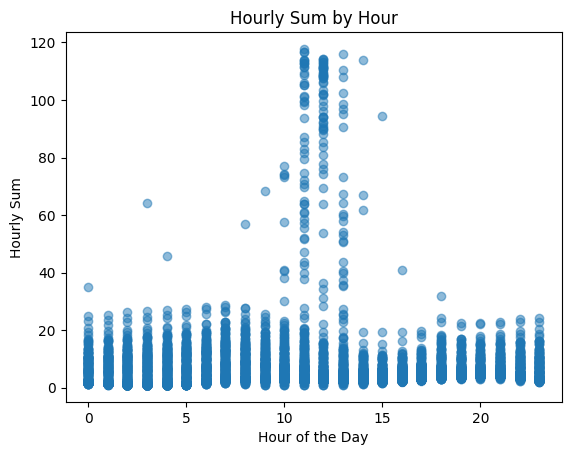

In [16]:
# by hour
plt.figure()
plt.scatter(combinedDatasetAssignment2['Hour'], combinedDatasetAssignment2['Hourly Sum'], alpha=0.5)
plt.title('Hourly Sum by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Hourly Sum')

If we look at the graph specifically by hour of the day, we see that energy usage starts to increase from about 8am, all the way until about 7pm. This matches our expectations, as those hours are usually when the majority of people and industry are active, therefore resulting in the increased hourly energy usage during the daylight hours. 

Text(0, 0.5, 'Hourly Sum')

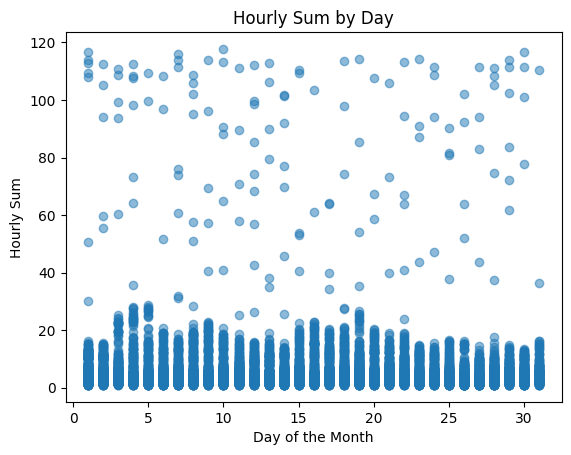

In [17]:
# by day 
plt.figure()
plt.scatter(combinedDatasetAssignment2['Day'], combinedDatasetAssignment2['Hourly Sum'], alpha=0.5)
plt.title('Hourly Sum by Day')
plt.xlabel('Day of the Month')
plt.ylabel('Hourly Sum')

Unsurprisingly, there doesn't seem to be too much of a pattern between which days of the month require more energy. Generally, we might expect there to be less power use on the weekend as industry doesn't run as much.

Text(0, 0.5, 'Hourly Sum')

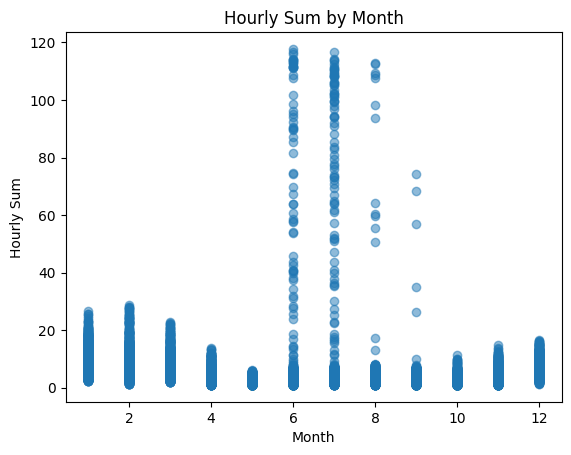

In [18]:
# by month
plt.figure()
plt.scatter(combinedDatasetAssignment2['Month'], combinedDatasetAssignment2['Hourly Sum'], alpha=0.5)
plt.title('Hourly Sum by Month')
plt.xlabel('Month')
plt.ylabel('Hourly Sum')

We see that usually in the summer months, as well as the winter months electricity usage tends to increase, with it being especially noticeable in the summer months. This is within expectations, as in the winter, a lot of heating is most likely due to the burning of natural gas heating, whereas in the summer, air conditioning usage is reliant on electricity, which causes electricity usage to spike significantly, as those tend to be extremely power hungry. Spring and fall tend to have lower energy usage as the climate tends to be nicer, and therefore not need climate control as much.

In [19]:
combinedDatasetAssignment2['Date/Time'] = pd.to_datetime(combinedDatasetAssignment2['Date/Time'])
combinedDatasetAssignment2.set_index('Date/Time', inplace=True)
hourly_data = combinedDatasetAssignment2.resample('H').sum()
daily_data = combinedDatasetAssignment2.resample('D').sum()
monthly_data = combinedDatasetAssignment2.resample('M').sum()

/var/folders/vz/z83bk0kd7s5d4_3cx59yyqnw0000gn/T/ipykernel_17911/3823209578.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = combinedDatasetAssignment2.resample('H').sum()
/var/folders/vz/z83bk0kd7s5d4_3cx59yyqnw0000gn/T/ipykernel_17911/3823209578.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = combinedDatasetAssignment2.resample('M').sum()


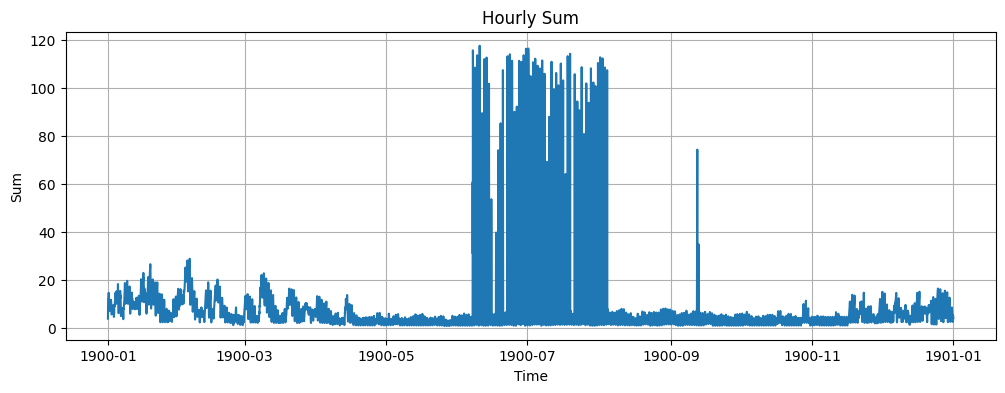

In [20]:
plt.figure(1, figsize=(12,4))
plt.plot(hourly_data.index, hourly_data['Hourly Sum'])
plt.title('Hourly Sum')
plt.xlabel('Time')
plt.ylabel('Sum')
plt.grid(True)

Unfortunately the index starts from 1900 due to that being the default of the DateTime package, but like before, if we look at the hourly sum across different months in time, we see that a lot more energy is consumed during the summer months, and slightly more energy is consumed during the winter. There do seem to be some outliers such as that spike in September, whether that's an outlier or a sudden weather change is unknown yet. 

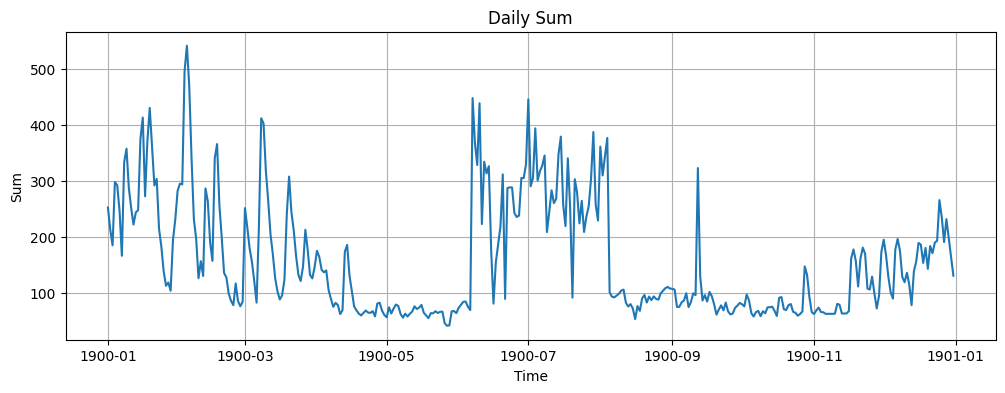

In [21]:
# Daily Data
plt.figure(1, figsize=(12,4))
plt.plot(daily_data.index, daily_data['Hourly Sum'])
plt.title('Daily Sum')
plt.xlabel('Time')
plt.ylabel('Sum')
plt.grid(True)

As expected, if we look at the daily sum instead, then the trend becomes much more smooth. We see that there's actually almost comparable peaks in the winter months to the summer months, with some of the highest peaks actually belonging to about February. This tells me that even though the hourly sum clearly shows a lot of energy being consumed in summer, significant variance is actually presence, therefore when we aggregate, the peaks aren't actually that much different than the winter months

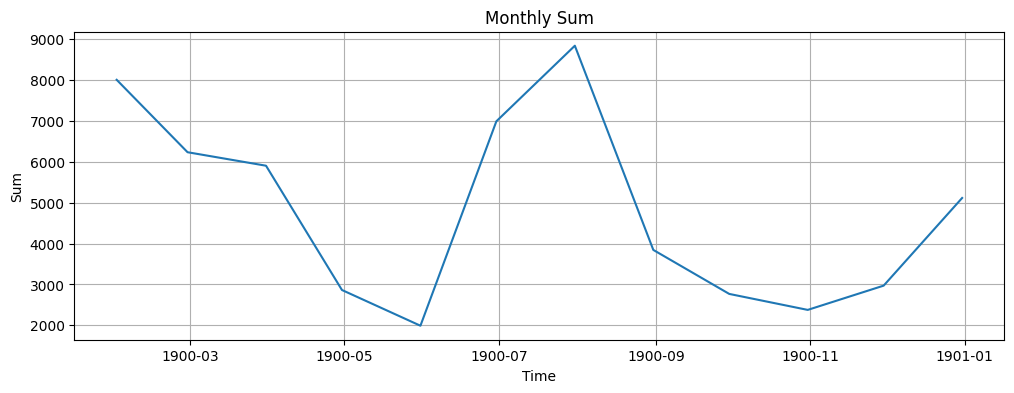

In [22]:
plt.figure(1, figsize=(12,4))
plt.plot(monthly_data.index, monthly_data['Hourly Sum'])
plt.title('Monthly Sum')
plt.xlabel('Time')
plt.ylabel('Sum')
plt.grid(True)

Like before, when we look at a monthly rolling sum instead, we see that the trend becomes even more smooth. Compared to the previous graphs, the seasons of spring and fall still consume the least amount of energy, but the winter and summer months have almost comparable energy peaks now, with the summer months only being slightly higher (9000 vs 8000). This supports the trend that while summer does tend to have higher energy usage, the variance present is also significantly higher. 

# Assignment 3: EDA and forecast model
Objective: create EDA and forecast model to predict RTLMP
We need to analyze and create predictive modeling in daily basis as quantitive analyst. Create EDA using the data and make your model to predict RTLMP from the data.

Data Files:
In the data file timeseries_data.xlsx, you can find following timeseries (hourly):
- RTLoad: ERCOT real-time hourly actual load
- WIND_RTI: ERCOT real-time hourly wind generation
- GENERATION_SOLAR_RT: ERCOT real-time solar generation
- RTLMP: ERCOT North hub real-time price

  
Requirements:
- Create Exploratory Data Analysis (EDA)
- Create forecast model to predict RTLMP


Hint:
- Notice the timestamps between independent and explanatory variables

In [23]:
#pip install openpyxl

In [24]:
#pip install seaborn

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

timesSeriesData = pd.read_excel('Documents/GitHub/GuzmanSummer2024/data/Assignment 3 - timeseries_data.xlsx')
timesSeriesData['ERCOT (WIND_RTI)'].fillna(timesSeriesData['ERCOT (WIND_RTI)'].median(), inplace=True)
timesSeriesData['ERCOT (GENERATION_SOLAR_RT)'].fillna(timesSeriesData['ERCOT (GENERATION_SOLAR_RT)'].median(), inplace=True)
timesSeriesData['hour'] = timesSeriesData['DATETIME'].dt.hour
timesSeriesData['dayofweek'] = timesSeriesData['DATETIME'].dt.dayofweek
timesSeriesData['month'] = timesSeriesData['DATETIME'].dt.month

# Exploratory Data Analysis (EDA)
# Descriptive Statistics
descriptive_stats = pd.DataFrame(timesSeriesData.describe())
descriptive_stats

Before analysis, I imputed the median of several columns to replace the nan - it's a more robust metric than the mean, which may not be ideal for our purposes if we're trying to find our value at risk or our 99% CVAR. If we look at the different columns, it's obvious that some metrics are meaningless, ie taking the mean of DATETIME or MARKETDAY. However, there's some more interesting statistics elsewhere. For example, we note that Wind generates significantly more energy than solar across all metrics. Whether this is due to more wind turbines and wind based electricity generation compared to few solar sources or if wind is just that much more productive will need to be deduced through other datasets and contextual knowledge.

In [ ]:
# Correlation Analysis: Calculate and plot the correlation matrix
corr_matrix = timesSeriesData[['HB_NORTH (RTLMP)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)']].corr()
pd.DataFrame(corr_matrix)

In [ ]:
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')

When we look at the correlation matrix, we see that the correlations in finance terms are surprisingly large, with correlations between Solar and RTLOAD at 0.47, and many of the other correlations being in the range of 0.15 to 0.24 in absolute value terms. 

In [ ]:
plt.figure(1, figsize=(12,4))
plt.plot(timesSeriesData['DATETIME'], timesSeriesData['HB_NORTH (RTLMP)'], color='blue')
plt.title('HB_NORTH (RTLMP) Over Time')
plt.ylabel('RTLMP ($)')

When we look at this data over time, we see that there are definitely years that contribute more - notably after 2018 there was a lot more value being generated here. Previous to 2018, RTLMP almost seemed to be consistently cyclical in nature. 

In [ ]:
# Plotting ERCOT (WIND_RTI)
plt.figure(1, figsize=(12,4))
plt.plot(timesSeriesData['DATETIME'], timesSeriesData['ERCOT (WIND_RTI)'], color='green')
plt.title('ERCOT (WIND_RTI) Over Time')
plt.ylabel('Wind Generation (MW)')

Wind RTI seems to be pretty constantly fluctuating over time, there might be some patterns to be gleaned from it, as it does seem to have "bumps" - 2017-01 to 2017-09 definitely looks like a bump happened, and then another bump happened from 2017-09 to 201801, and the third from 2018-01 to 2018-09. It would be worth looking into it more closely in the future to separate out noise from an actual trend.

In [ ]:
# Plotting ERCOT (GENERATION_SOLAR_RT)
plt.figure(1, figsize=(12,4))
plt.plot(timesSeriesData['DATETIME'], timesSeriesData['ERCOT (GENERATION_SOLAR_RT)'], color='orange')
plt.title('ERCOT (GENERATION_SOLAR_RT) Over Time')
plt.ylabel('Solar Generation (MW)')

Solar generation looks like it's pretty consistently increased over time, and the generation does seem to appear to be relatively cyclical as well, every few months there's a notable drop. Whether this is from weather patterns or maintence to temporarily take solar farms off line, or if it's just noise requires further analysis. However, it is clear that solar power has grown, and most likely will continue to grow.

In [ ]:
# Plotting ERCOT (RTLOAD)
plt.figure(1, figsize=(12,4))
plt.plot(timesSeriesData['DATETIME'], timesSeriesData['ERCOT (RTLOAD)'], color='red')
plt.title('ERCOT (RTLOAD) Over Time')
plt.ylabel('Real-Time Load (MW)')
plt.xlabel('Date')

RT Load seems to be very cyclical in nature, just the not even 2 years data that we have here already show two pretty big increases, and both starting in May. There's a peak in 2018-01, and it looks to be similar to the peak that occured in 2017-01. However, we lack the data to further analyze this and determine if it's a true effect or random chance alone. 

In [ ]:
#pip install keras

In [ ]:
#pip install tensorflow

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")
timesSeries = pd.read_excel('Documents/GitHub/GuzmanSummer2024/data/Assignment 3 - timeseries_data.xlsx')
timesSeries['ERCOT (WIND_RTI)'].fillna(timesSeries['ERCOT (WIND_RTI)'].median(), inplace=True)
timesSeries['ERCOT (GENERATION_SOLAR_RT)'].fillna(timesSeries['ERCOT (GENERATION_SOLAR_RT)'].median(), inplace=True)
timesSeries.set_index('DATETIME', inplace=True)

# Seasonality
result = seasonal_decompose(timesSeries['HB_NORTH (RTLMP)'], model='additive', period=24)
result.plot()
plt.show()

train_data = timesSeries['HB_NORTH (RTLMP)'][:int(0.8*len(timesSeries))]
test_data = timesSeries['HB_NORTH (RTLMP)'][int(0.8*len(timesSeries)):]

# Fit the SARIMA model
sarima_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
sarima_result = sarima_model.fit()
forecast = sarima_result.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, dynamic=False)

# Evaluate the model
mae = mean_absolute_error(test_data, forecast)
mse = mean_squared_error(test_data, forecast)
print(f'MAE: {mae}, MSE: {mse}')


In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.show()

SARIMAX is one of the more commonly used tools for times-series analysis, being able to decompose the data into several metrics like seasonality, which is important for us as we expect and have shown greater energy usage during summer and winter when compared to the other months. 

However, some of it looks off, therefore I've decided to utilize an XGBoost tree algorithm with varied lookback periods to see if it will be a better model. 

In [ ]:
#pip install xgboost

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
warnings.filterwarnings("ignore")

forecast = timesSeries[['HB_NORTH (RTLMP)']]
def create_lag_features(data, lags):
    for lag in lags:
        data[f'lag_{lag}'] = data['HB_NORTH (RTLMP)'].shift(lag)
    return data.dropna()

# Define different lag periods
lag_periods = [1, 24, 168, 1008] # hourly, daily, montly, half-month

results = {}
for lag in lag_periods:
    data_with_lags = create_lag_features(forecast.copy(), range(1, lag + 1))
    

    train_size = int(len(data_with_lags) * 0.8)
    train_data = data_with_lags[:train_size]
    test_data = data_with_lags[train_size:]
    X_train = train_data.drop(columns=['HB_NORTH (RTLMP)'])
    y_train = train_data['HB_NORTH (RTLMP)']
    X_test = test_data.drop(columns=['HB_NORTH (RTLMP)'])
    y_test = test_data['HB_NORTH (RTLMP)']
    
    # Scale the data - compare apples to apples, make sure scale isn't causing spurious correlations
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results[lag] = {'MAE': mae, 'MSE': mse}
    
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, y_test, label='Actual', alpha = 0.5)
    plt.plot(test_data.index, y_pred, label='Predicted', alpha = 0.5)
    plt.title(f'XGBoost with Lag {lag} - MAE: {mae:.2f}, MSE: {mse:.2f}')
    plt.legend()
    plt.show()

for lag, metrics in results.items():
    print(f'Lag {lag}: MAE = {metrics["MAE"]:.2f}, MSE = {metrics["MSE"]:.2f}')


We see that in general, the longer the lookback period is, the better the model is able to predict. However, the model still doesn't perform as extreme as the original data, we see several peaks where the model is extremely off, and requires further refinement.  

# Assignment 4 (Optional): Learn products of Futures
Objective: self-learning of market products and create hedging method
This assignment will give some information to guide you to learn U.S. Power Futures market products. The goal is to demonstrate self-learning skill and passion to explore/learn new market/products.

Products:
- Product 1: Power Futures - ERN https://www.theice.com/products/6590337/ERCOT-North-345KV-Real-Time-Peak-Fixed-Price-Future
- Product 2: Natural Gas Futures - H https://www.theice.com/products/6590258/Henry-LD1-Fixed-Price-Future
- Product 3: Heat Rate Futures - XPR https://www.theice.com/products/27998706/ERCOT-North-345KV-Physical-HR-Peak-HE-0700-2200-Future

Data Files:
- dataset.xlsx the file provides the time series of daily settlement prices for same strip (December 2016 product).

Requirements:
- create understanding of the products from the links provided. (do more research with uncleared concepts)
- assume Product 1 has no liquidation in the market and we are holding the physical power (same settlement as Product 1), how to use Product 2 & 3 to hedge our exposure to physical power (again, same settlement as Product 1)?
- create Excel file model with weekly rebalance of your positions (only rebalance Product 2) to try to achieve hedging. within the Excel
file, use parameter to decide your rebalance and summarize the efficiency of hedging.

Hint:
- make your own assumptions and explain in summary report
- notice contract size limit

In [ ]:
dataAssignment4 = pd.read_excel("Documents/GitHub/GuzmanSummer2024/data/Assignment 4 - dataset.xlsx")
dataAssignment4

## Understanding of the links provided:

There's three different links provided:
The first link: ERCOT Power Future
This is a derivatives future contract that allows buyers and sellers to lock in the price of 1 megawatt of electricity certain time in advance. Notably, this is cash settled as opposed to physical delivery.

The second link: Henry LD1 Fixed Price Future 
Like before, this is also a cash settled derivative futures contract on natural gas instead of electricity, trading specifically in 2500 MMBtu's. 

The third link: Physical HR Peak HE 
This unlike the previous two, appears to be a forward derivatives contract instead. It's traded OTC, and also has a daily settlement term labelled on it, which are usually more standard for forwards contracts. We would have to be careful of trading these products as it may be more likely for there to be less liquidity for these products when compared to futures, which are traded on exchanges. 

## Assume Product 1 has no liquidation in the market and we are holding the physical power (same settlement as Product 1), how to use Product 2 & 3 to hedge our exposure to physical power (again, same settlement as Product 1)?

If we are holding the physical power, then we want to sell contracts of product 1 - in the future, the buyer agrees to pay us however much we agree on, scaled by the amount of MW we want to sell. However, since we know that product 1 has no liquidity, it implies that the bid-ask spread will be large. However, we also have Products 2 and 3, which although are not electricity specifically, are similar in the sense that they are both energy products. Therefore, we could sell the physical power that we do have (Product 1), and then buy Product 2 and 3 to hedge our exposure to the physical power directly by using these alternative energy assets that most likely will be correlated. 